In [ ]:
import cv2
import numpy as np
import pynq_dpu
import matplotlib.pyplot as plt
import scipy.ndimage
import time

# Przetwarzanie wstępne obrazu

In [ ]:
image_size = (200, 200)
def softmax(x: np.ndarray, axis=1):
    return np.exp(x) / np.sum(np.exp(x), axis=axis)

def preprocess_image(img_file, img_size):
    # Wczytanie obrazu
    img = cv2.imread(img_file, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Nie udało się wczytać obrazu: {img_file}")
        return None
    # Zmiana rozmiaru obrazu
    img = cv2.resize(img, img_size)
    # Konwersja obrazu na odcienie szarości i normalizacja
    img_preprocessed = img.mean(-1) / 255
    # Konwersja obrazu z BGR na RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Wyświetlenie obrazu
    plt.imshow(img_rgb)
    plt.axis('off')  # Ukrycie osi
    plt.show()
    print(f"Obraz {img_file} został przetworzony i wyświetlony.")
    return img_preprocessed

# Uruchomienie Superpoint na DPU

In [ ]:
class NetworkDPU:
    
    def __init__(self, xmodel_path: str = 'MiniResNet_qu.xmodel', dpu_path: str = 'dpu.bit'):
        self.ov: pynq_dpu.DpuOverlay = pynq_dpu.DpuOverlay(dpu_path, download=True)
        self.ov.load_model(xmodel_path)
        self.dpu = self.ov.runner
        print(self.ov.runner)
        inputTensors = self.dpu.get_input_tensors()
        outputTensors = self.dpu.get_output_tensors()
        # get list of shapes
        shapeIn = np.array([it.dims for it in inputTensors])
        shapeOut = np.array([ot.dims for ot in outputTensors])
        self.shapeIn = shapeIn
        self.shapeOut = shapeOut
        self.buff_in = [np.zeros(sh, np.int8, order='C') for sh in shapeIn]
        self.buff_out = [np.zeros(sh, np.int8, order='C') for sh in shapeOut]
        
        self.input_repr = [(it.get_attr('bit_width'), it.get_attr('fix_point')) for it in inputTensors]
        self.output_repr = [(ot.get_attr('bit_width'), ot.get_attr('fix_point')) for ot in outputTensors]
    
    def input_float_to_int8(self, x: np.ndarray) -> np.ndarray:
        BIT_WIDTH, PRECISION_BITS = self.input_repr[0]
        x = x * (2**PRECISION_BITS)
        x = np.floor(x)
        x = np.clip(x,-128, 127)
        return x.astype(np.int8)
    
    def output_int8_to_float(self, y: np.ndarray):
        BIT_WIDTH, PRECISION_BITS = self.output_repr[0]
        PRECISION = 1 / 2**PRECISION_BITS
        y = y * PRECISION
        return y.astype(np.float32)
    
    def process(self, x: np.ndarray):
        x = self.input_float_to_int8(x)
        self.buff_in[0] = x
        # start DPU thread
        job_id = self.dpu.execute_async(self.buff_in, self.buff_out)
        self.dpu.wait(job_id)
        scores = self.buff_out[1]
        scores = self.output_int8_to_float(scores)
        descriptors_dense = self.buff_out[0]
        descriptors_dense = self.output_int8_to_float(descriptors_dense)
        scores = softmax(scores)[:, :, :, :-1]
        b, h, w, _ = scores.shape
        scores = scores.reshape(b, h, w, 8, 8)
        scores = scores.transpose(0, 1, 3, 2, 4).reshape(b, h * 8, w * 8)
        
        return scores, descriptors_dense
    
    def __call__(self, x: np.ndarray):
        return self.process(x)

# Post processing punktów i deskryptorów

In [232]:
def sample_descriptors(keypoints, descriptors, s: int = 8):
    """Interpoluje deskryptory w lokalizacjach kluczowych punktów dla pojedynczego obrazu."""
    h, w, c = descriptors.shape
    keypoints = (keypoints + 0.5) / (np.array([w, h]) * s)
    keypoints = keypoints * 2 - 1  # normalizacja do zakresu (-1, 1)

    num_keypoints = keypoints.shape[0]
    sampled_descriptors = np.zeros((num_keypoints, c), dtype=descriptors.dtype)
    x = ((keypoints[:, 0] + 1) / 2) * (w - 1)
    y = ((keypoints[:, 1] + 1) / 2) * (h - 1)
    for ch in range(c):
        sampled_descriptors[:, ch] = scipy.ndimage.map_coordinates(
            descriptors[:,:,ch], [[y], [x]], order=1, mode='nearest')

    norms = np.linalg.norm(sampled_descriptors, axis=1, keepdims=True)
    descriptors_normalized = sampled_descriptors / (norms + 1e-6)
    return descriptors_normalized

def nms(scores, nms_radius: int):
    """Wykonuje nienadzorowaną maksymalną supresję (NMS) na mapie skorelowanych punktów."""
    assert nms_radius >= 0

    def max_pool(x, size):
        return scipy.ndimage.maximum_filter(x, size=size, mode='constant', cval=0.0)

    max_mask = scores == max_pool(scores, nms_radius * 2 + 1)
    suppressed_scores = np.where(max_mask, scores, 0)
    return suppressed_scores

def post_processing(scores, descriptors_dense, nms_radius=4, score_threshold=0.005, s=8):
    """Przetwarza mapy skorelowanych punktów i gęstych deskryptorów, aby uzyskać kluczowe punkty i ich deskryptory."""
    scores = nms(scores, nms_radius)
    pad = 4
    scores[:pad] = -1
    scores[:, :pad] = -1
    scores[-pad:] = -1
    scores[:, -pad:] = -1
    idxs = np.where(scores > score_threshold)
    keypoints = np.stack(idxs[::-1], axis=-1).astype(float)

    # Normalizacja deskryptorów
    norms = np.linalg.norm(descriptors_dense, axis=0, keepdims=True)
    descriptors_dense = descriptors_dense / (norms + 1e-6)

    # Interpolacja deskryptorów w lokalizacjach kluczowych punktów
    descriptors = sample_descriptors(keypoints, descriptors_dense, s)

    return keypoints, descriptors


# Łączenie punktów

In [258]:
def match_descriptors(kp1, desc1, kp2, desc2):
    # Match the keypoints with the warped_keypoints with nearest neighbor searc
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    matches = bf.match(desc1, desc2)
    
    matches_idx = np.array([m.queryIdx for m in matches])
    m_kp1 = [kp1[idx] for idx in matches_idx]
    matches_idx = np.array([m.trainIdx for m in matches])
    m_kp2 = [kp2[idx] for idx in matches_idx]

    return m_kp1, m_kp2, matches

def compute_homography(matched_kp1, matched_kp2):
    matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC)
    inliers = inliers.flatten()
    return H, inliers

def match_points(scores1, descriptors1, scores2, descriptors2):

    keypoints1 = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in scores1]
    keypoints2 = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in scores2]

    m_kp1, m_kp2, matches = match_descriptors(keypoints1, descriptors1, keypoints2, descriptors2)
    H, inliers = compute_homography(m_kp1, m_kp2)
    matches = np.array(matches)[inliers.astype(bool)].tolist()
    return matches, keypoints1, keypoints2

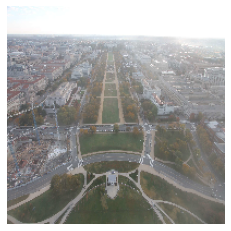

Obraz 1.ppm został przetworzony i wyświetlony.


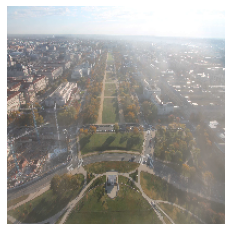

Obraz 2.ppm został przetworzony i wyświetlony.


In [ ]:
img_file = "1.ppm"
img_preprocessed = preprocess_image(img_file, image_size)

img_file = "2.ppm"
img_preprocessed_2 = preprocess_image(img_file, image_size)

In [ ]:
net = NetworkDPU(xmodel_path='SuperPoint_qu.xmodel', 
                 dpu_path='dpu.bit')

vart::Runner@0xaaaaea803520


In [ ]:
start_time = time.perf_counter()
y_pred1 = net(img_preprocessed)
y_pred2 = net(img_preprocessed_2)

end_time = time.perf_counter()
execution_time = (end_time - start_time) * 1000 /2
print(f"Time: {execution_time:.6f} ms")

Time: 27.324713 ms


In [233]:
start_time = time.perf_counter()
scores1, descriptors1 = post_processing(y_pred1[0][0], y_pred1[1][0])
scores2, descriptors2 = post_processing(y_pred2[0][0], y_pred2[1][0])
end_time = time.perf_counter()
execution_time = (end_time - start_time) * 1000 / 2
print(f"Time: {execution_time:.6f} ms")

Time: 71.446887 ms


In [259]:
start_time = time.perf_counter()
matches, k1, k2 = match_points(scores1, descriptors1, scores2, descriptors2)
end_time = time.perf_counter()
execution_time = (end_time - start_time) * 1000
print(f"Time: {execution_time:.6f} ms")

Time: 57.759404 ms


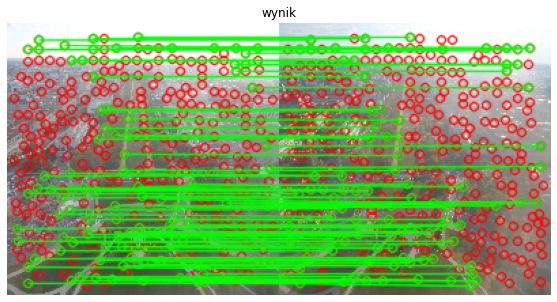

In [260]:
img1 = cv2.imread(f'1.ppm', cv2.IMREAD_COLOR)
img1 = cv2.resize(img1, image_size)
img2 = cv2.imread(f'2.ppm', cv2.IMREAD_COLOR)
img2 = cv2.resize(img2, image_size)
matched_img = cv2.drawMatches(img1, k1, img2, k2, matches,
                                    None, matchColor=(0, 255, 0),
                                    singlePointColor=(0, 0, 255))
matched_rgb = cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)

# Wyświetlenie obrazu w Jupyter Notebook
plt.figure(figsize=(10, 5))
plt.imshow(matched_rgb)
plt.title("wynik")
plt.axis("off")  # Ukrycie osi
plt.show()

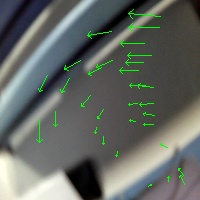

FPS: 2.445763
pre: 11.171658 ms | net: 20.867284 ms | post: 67.218158 ms | matching: 309.613260 ms | all: 408.870360
Zatrzymano kamerę
Średnie czasy (ms): pre: 12.695428 | net: 21.219215 | post: 65.866192 | matching: 67.859394 | all: 167.640229


In [263]:
import cv2
from IPython.display import display, Image
import ipywidgets as widgets
from IPython.display import clear_output

# Inicjalizacja kamery (0 - domyślna kamera)
cap = cv2.VideoCapture(0)
last_scores = None
last_descriptors = None
time4 = 0
pre_times = []
net_times = []
post_times = []
matching_times = []
all_times = []
if not cap.isOpened():
    print("Nie można otworzyć kamery")
else:
    try:
        while True:
            start_time = time.perf_counter()

            ret, frame = cap.read()
            if not ret:
                print("Nie udało się pobrać obrazu")
                break

            # Konwersja do formatu RGB (OpenCV używa BGR)
            #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = cv2.resize(frame, image_size)
            img_preprocessed = img.mean(-1) / 255
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            time1 = time.perf_counter()

            y_pred = net(img_preprocessed)
            time2 = time.perf_counter()

            scores, descriptors = post_processing(y_pred[0][0], y_pred[1][0])
            time3 = time.perf_counter()
            
            if last_descriptors is not None:
                matches, k1, k2 = match_points(scores, descriptors, last_scores, last_descriptors)

                for match in matches:
                    pt1 = tuple(map(int, k1[match.queryIdx].pt))
                    pt2 = tuple(map(int, k2[match.trainIdx].pt))
                    cv2.arrowedLine(img_rgb, pt2, pt1, (0, 255, 0), 1, tipLength=0.2)
            last_descriptors = descriptors
            last_scores = scores
            # Wyświetlenie obrazu w notebooku
            clear_output(wait=True)
            display(Image(data=cv2.imencode('.jpg', img_rgb)[1].tobytes()))
            end_time = time.perf_counter()
            execution_time = (end_time - start_time)
            print(f"FPS: {1/execution_time:.6f}")
            print(f"pre: {(time1 - start_time)*1000:.6f} ms | net: {(time2 - time1)*1000:.6f} ms | post: {(time3 - time2)*1000:.6f} ms | matching: {(end_time - time3)*1000:.6f} ms | all: {(execution_time)*1000:.6f}")
            pre_times.append(time1 - start_time)
            net_times.append(time2 - time1)
            post_times.append(time3 - time2)
            matching_times.append(end_time - time3)
            all_times.append(execution_time)

    except KeyboardInterrupt:
        print("Zatrzymano kamerę")
        num_iterations = len(pre_times) - 1
        avg_pre = sum(pre_times[1:]) / num_iterations * 1000
        avg_net = sum(net_times[1:]) / num_iterations * 1000
        avg_post = sum(post_times[1:]) / num_iterations * 1000
        avg_matching = sum(matching_times[1:]) / num_iterations * 1000
        avg_all = sum(all_times[1:]) / num_iterations * 1000
        print(f"Średnie czasy (ms): pre: {avg_pre:.6f} | net: {avg_net:.6f} | post: {avg_post:.6f} | matching: {avg_matching:.6f} | all: {avg_all:.6f}")

    cap.release()
    cv2.destroyAllWindows()
